https://sites.google.com/site/earthengineapidocs/tutorials/global-forest-change-tutorial

https://earthenginepartners.appspot.com/science-2013-global-forest/download_v1.7.html

https://developers.google.com/earth-engine/datasets/catalog/UMD_hansen_global_forest_change_2022_v1_10

In [2]:
import numpy as np
import datetime
import os
import glob
import json
import pandas as pd
import geopandas as gpd

from functools import reduce

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors

import plotly.express as px
import plotly.graph_objects as go

In [3]:
# Rasterio
import rasterio
from rasterio.plot import show
from rasterio.mask import mask

#Scipy
from scipy.signal import medfilt2d

# bs4
import requests
from bs4 import BeautifulSoup

In [4]:
from functools import reduce  # Import the reduce function

In [5]:
import ee
from IPython.display import Image

In [6]:
ee.Authenticate()

True

In [7]:
ee.Initialize(project='ee-mnmx0101-ifad')

In [8]:
# Set Home Directory
home = 'C:\\Users\\hadunka2\\OneDrive - University of Illinois - Urbana\\Documents\\charcoal_project'
home

'C:\\Users\\ck24\\OneDrive - University of Illinois - Urbana\\Documents\\ifad_project'

# Start Retrieiving (SPEI)

In [26]:
# Load a Landsat 8 ImageCollection for a single path-row.
collection = ee.ImageCollection("CSIC/SPEI/2_9").filterDate('2014-07-01', '2014-08-01')               
#.filter(ee.Filter.eq('WRS_PATH', 44))\
               #.filter(ee.Filter.eq('WRS_ROW', 34))\
               
print('Collection: ')
collection.getInfo()['features']

Collection: 


[{'type': 'Image',
  'bands': [{'id': 'SPEI_01_month',
    'data_type': {'type': 'PixelType', 'precision': 'float'},
    'dimensions': [720, 360],
    'crs': 'EPSG:4326',
    'crs_transform': [0.5, 0, -180, 0, -0.5, 90]},
   {'id': 'SPEI_02_month',
    'data_type': {'type': 'PixelType', 'precision': 'float'},
    'dimensions': [720, 360],
    'crs': 'EPSG:4326',
    'crs_transform': [0.5, 0, -180, 0, -0.5, 90]},
   {'id': 'SPEI_03_month',
    'data_type': {'type': 'PixelType', 'precision': 'float'},
    'dimensions': [720, 360],
    'crs': 'EPSG:4326',
    'crs_transform': [0.5, 0, -180, 0, -0.5, 90]},
   {'id': 'SPEI_04_month',
    'data_type': {'type': 'PixelType', 'precision': 'float'},
    'dimensions': [720, 360],
    'crs': 'EPSG:4326',
    'crs_transform': [0.5, 0, -180, 0, -0.5, 90]},
   {'id': 'SPEI_05_month',
    'data_type': {'type': 'PixelType', 'precision': 'float'},
    'dimensions': [720, 360],
    'crs': 'EPSG:4326',
    'crs_transform': [0.5, 0, -180, 0, -0.5, 90]},
  

In [27]:
class RASTER_RETRIEVE:
    
    def __init__(self, image_address, start_date='2020-01-01', end_date='2024-01-01', scale=30):
        self.collection = ee.ImageCollection(image_address).filterDate(start_date, end_date)
        self.scale = scale
        
    def gpd_geom_to_ee(self, geom):
        """Convert a GeoPandas geometry to an Earth Engine geometry."""
        ee_geometry = None  # Initialize ee_geometry
        if geom.type == 'Polygon':
            coordinates_list = []
            for interior in geom.interiors:
                coordinates_list.append(list(interior.coords))
            ee_geometry = ee.Geometry.Polygon([list(geom.exterior.coords)] + coordinates_list)
        elif geom.type == 'MultiPolygon':
            polygons = [list(poly.exterior.coords) for poly in geom]
            ee_geometry = ee.Geometry.MultiPolygon(polygons)
        else:
            raise ValueError(f"Unsupported geometry type: {geom.type}")
        return ee_geometry
    
    def summarize_raster(self, polygon, image_id):
        """Summarize raster data within a given GeoDataFrame by date."""
        results = []
#        for geom in tqdm(geo_df.geometry, desc='Processing Precipitation'):
        ee_geometry = self.gpd_geom_to_ee(polygon)
        date_value_stats = []
        for image in tqdm(self.collection.toList(self.collection.size()).getInfo()):
            date = ee.Image(image['id']).date().format().getInfo()
            value = ee.Image(image['id']).select(image_id)
            stats = value.reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=ee_geometry,
                scale=self.scale,
                maxPixels=1e9
            )
            result_value = stats.getInfo().get(image_id, None)
            date_value_stats.append((date, result_value))
        results.append(date_value_stats)
        return results


In [28]:
priority_country_code_mapping = {
    'AFG': 'AF',  # Afghanistan
    'BDI': 'BY',  # Burundi
    'CAF': 'CT',  # Central African Republic
    'COD': 'CG',  # Democratic Republic of the Congo
    'ETH': 'ET',  # Ethiopia
    'KEN': 'KE',  # Kenya
    'SOM': 'SO',  # Somalia
    'SSD': 'OD',  # South Sudan
    'SDN': 'SU',  # Sudan
    'TZA': 'TZ',  # Tanzania
    'MDG': 'MA',  # Madagascar
    'MWI': 'MI',  # Malawi
    'GTM': 'GT',  # Guatemala
    'HTI': 'HA',  # Haiti
    'LBN': 'LE',  # Lebanon
    'YEM': 'YM',  # Yemen
}

zambia = {
    'ZMB': 'ZM'}

<AxesSubplot:>

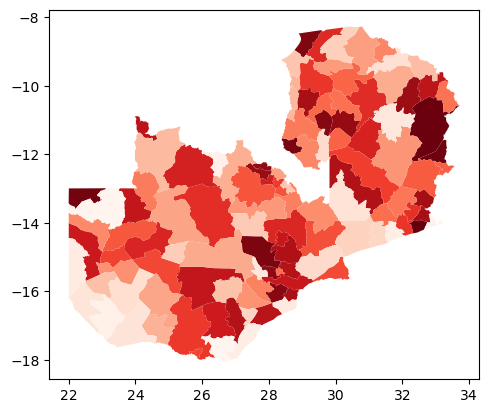

In [29]:
import geopandas as gpd
import json
import requests
from shapely.geometry import shape

geoconcat = []

adm_level = 'ADM2'

for country_code in zambia.keys():
    r = requests.get(f"https://www.geoboundaries.org/api/current/gbOpen/{country_code}/{adm_level}/")
    dlPath = r.json()['gjDownloadURL']
    geoBoundary = requests.get(dlPath).json()


    # Convert the dictionary to a GeoPandas dataframe
    geodf = gpd.GeoDataFrame.from_features(geoBoundary['features'], crs=geoBoundary['crs']['properties']['name'])
    geoconcat.append(geodf)

geo_df_adm1 = pd.concat(geoconcat)

geo_df_adm1.plot(column = 'shapeName', cmap = 'Reds_r')

In [30]:
country_code = 'ZMB'

# Example function that processes a single geometry - this needs to be defined
def process_geometry(geom):
    analysis = RASTER_RETRIEVE(image_address = "CSIC/SPEI/2_9")  # projects/UNFAO/ASIS/ASI_D
    return analysis.summarize_raster(geom, 'SPEI_24_month') #

# Assuming 'geo_df_adm1' is your GeoDataFrame
temp_df = geo_df_adm1[geo_df_adm1['shapeGroup']==country_code].copy()  # Example: limiting to first 2 entries for illustration


In [31]:
class RASTER_RETRIEVE:
    
    def __init__(self, image_address, start_date='2020-01-01', end_date='2024-01-01', scale=30):
        self.collection = ee.ImageCollection(image_address).filterDate(start_date, end_date)
        self.scale = scale
        
    def gpd_geom_to_ee(self, geom):
        """Convert a GeoPandas geometry to an Earth Engine geometry."""
        ee_geometry = None  # Initialize ee_geometry
        if geom.type == 'Polygon':
            coordinates_list = []
            for interior in geom.interiors:
                coordinates_list.append(list(interior.coords))
            ee_geometry = ee.Geometry.Polygon([list(geom.exterior.coords)] + coordinates_list)
        elif geom.type == 'MultiPolygon':
            polygons = [list(poly.exterior.coords) for poly in geom]
            ee_geometry = ee.Geometry.MultiPolygon(polygons)
        else:
            raise ValueError(f"Unsupported geometry type: {geom.type}")
        return ee_geometry
    
    def summarize_raster(self, polygon, image_id):
        """Summarize raster data within a given GeoDataFrame by date."""
        results = []
#        for geom in tqdm(geo_df.geometry, desc='Processing Precipitation'):
        ee_geometry = self.gpd_geom_to_ee(polygon)
        date_value_stats = []
        for image in tqdm(self.collection.toList(self.collection.size()).getInfo()):
            date = ee.Image(image['id']).date().format().getInfo()
            value = ee.Image(image['id']).select(image_id)
            stats = value.reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=ee_geometry,
                scale=self.scale,
                maxPixels=1e9
            )
            result_value = stats.getInfo().get(image_id, None)
            date_value_stats.append((date, result_value))
        results.append(date_value_stats)
        return results


In [32]:
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm

In [ ]:
# Use ThreadPoolExecutor to parallelize the processing
results = []

with ThreadPoolExecutor(max_workers=1) as executor:  # Adjust `max_workers` as needed
    futures = [executor.submit(process_geometry, geom) for geom in temp_df.geometry]
    for future in as_completed(futures):
        results.append(future.result())

 33%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                 | 12/36 [00:09<00:18,  1.32it/s]